# TDEM response of a conductive permeable casing 
- inductive source: 100m loop centered above casing
- resistive background ($10^{-4}$ S/m background; same as air)
- conductive ($10^6$ S/m), permeable (variable) casing (2000m long)

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
import ipywidgets
import properties
import time 

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps
from SimPEG.Utils import Zero

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

In [2]:
# create a simulation directory where results can be saved. 
simDir = 'TDEM_Augustin'  

In [3]:
# permeabilities to model
casing_mur = [1, 100]
sigma_casing = [1e6, 1000353, 1e8]

In [4]:
# background parameters
sigma_air = 1e-4
sigma_back = 1e-4
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter
casing_l = 2000

def get_model(mur, sigc):
    model = casingSim.model.CasingInHalfspace(
        directory = simDir,
        sigma_air = sigma_air,
        sigma_casing = sigc,  # conductivity of the casing (S/m)
        sigma_back = sigma_back,  # conductivity of the background (S/m)
        sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
        casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
        casing_l = casing_l,
        casing_t = casing_t, 
        mur_casing = mur,
        src_a = np.r_[0., 0., 0.],
        src_b = np.r_[0., 0., 0.]
    )
 
    return model

## store the different models


In [5]:
model_names_permeable = ["casing_{}".format(mur) for mur in casing_mur]
model_names_conductive = ["casing_{:1.0e}".format(sig) for sig in sigma_casing]

# conductive, permeable models
model_dict_permeable = {
    key: get_model(mur, 1e6) for key, mur in zip(model_names_permeable, casing_mur)
}

model_dict_conductive = {
    key: get_model(1, sig) for key, sig in zip(model_names_conductive, sigma_casing)
}

model_names = model_names_conductive + model_names_permeable
model_dict = {}
model_dict.update(model_dict_permeable)
model_dict.update(model_dict_conductive)

# # permeable models (conductivity = wholespace)
# model_dict_resistive = {
#     key: get_model(mur, sigma_back) for key, mur in zip(model_names, casing_mur)
# }

In [6]:
model_dict["baseline"] = model_dict[model_names[0]].copy()
model_dict["baseline"].sigma_casing = model_dict["baseline"].sigma_back
model_names = ["baseline"] + model_names
model_names

['baseline',
 'casing_1e+06',
 'casing_1e+06',
 'casing_1e+08',
 'casing_1',
 'casing_100']

## Create a mesh

In [7]:
# parameters defining the core region of the mesh
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 100  # go out 500m from the well

# padding parameters
npadx, npadz = 23, 30  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
def get_mesh(mod):
    return casingSim.CasingMeshGenerator(
        directory=simDir,  # directory where we can save things
        modelParameters=mod,  # casing parameters
        npadx=npadx,  # number of padding cells in the x-direction
        npadz=npadz,  # number of padding cells in the z-direction
        domain_x=domainx2,  # extent of the second uniform region of the mesh 
#         hy=hy,   # cell spacings in the 
        csx1=mod.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
        csx2=csx2,  # second core cell size
        csz=csz,  # cell size in the z-direction
        pfx2=pfx2,  # padding factor to "infinity"
        pfz=pfz  # padding factor to "infinity" for the z-direction
    )

In [8]:
mesh_generator = get_mesh(model_dict[model_names[0]])

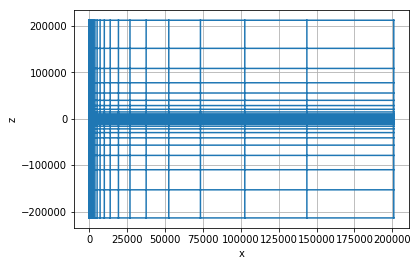

In [9]:
mesh_generator.mesh.plotGrid()

In [10]:
# Assign physical properties on the mesh
physprops = {
    name: casingSim.model.PhysicalProperties(mesh_generator, mod) 
    for name, mod in model_dict.iteritems()
}

# physprops_resistive = {
#     name: casingSim.model.PhysicalProperties(mesh_generator, mod) 
#     for name, mod in model_dict_resistive.iteritems()
# }

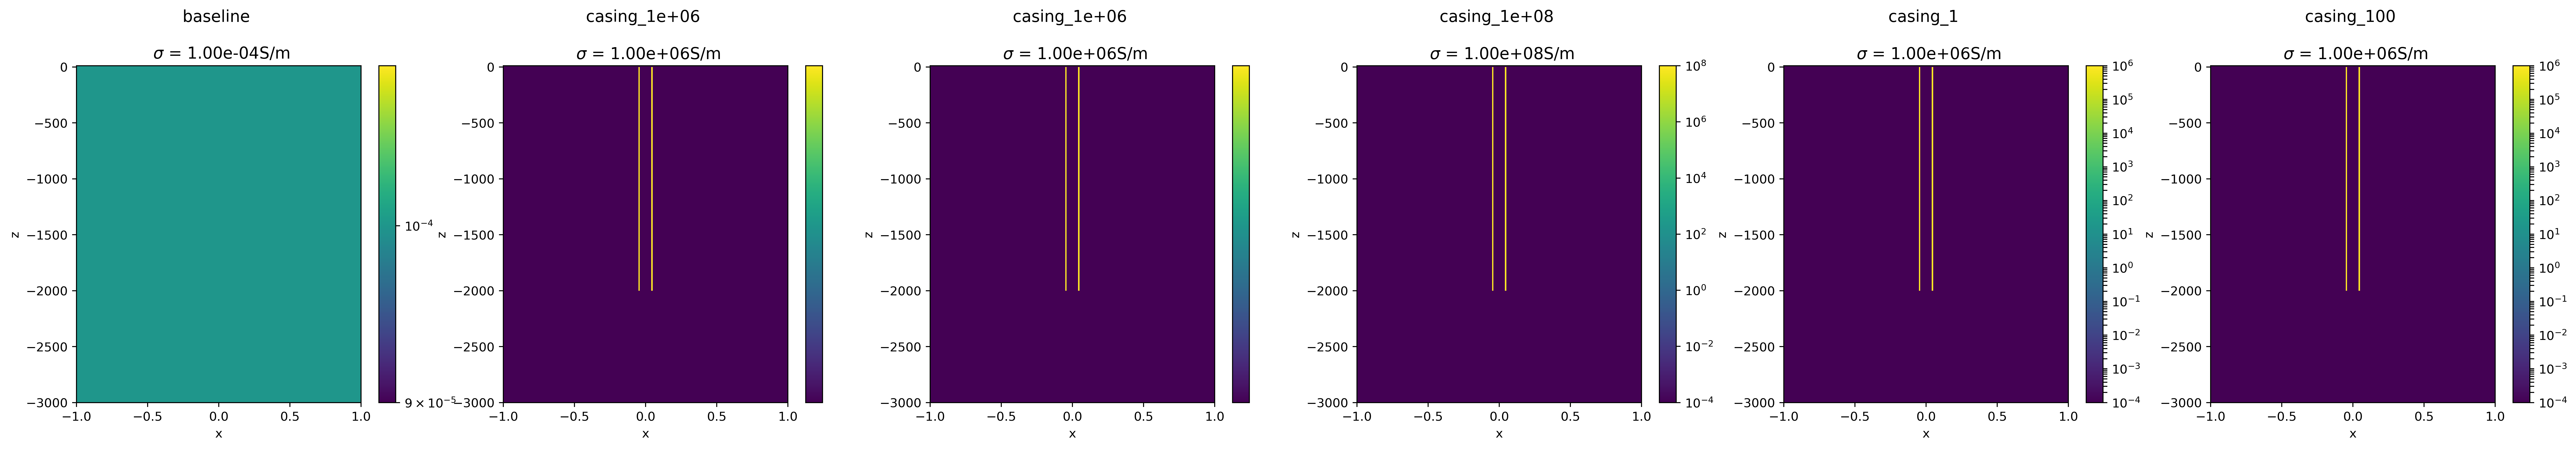

In [11]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physprops[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

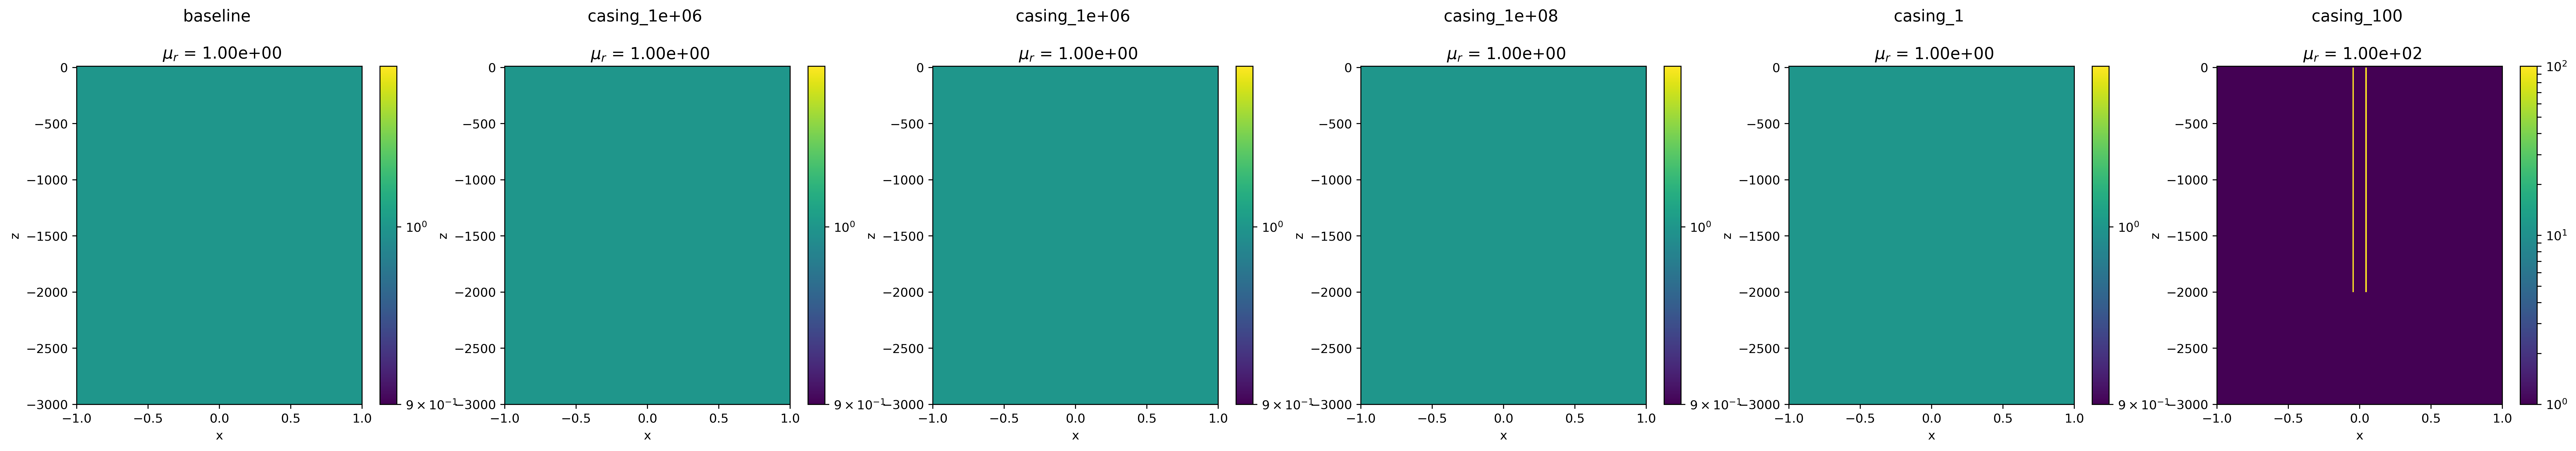

In [12]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physprops[title]
    pp.plot_mur(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\mu_r$ = {:1.2e}'.format(title, pp.modelParameters.mur_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

## Set up the time domain EM problem 

In [13]:
nsteps = 40
timeSteps = [
    (1e-6, nsteps), (5e-6, nsteps), (1e-5, nsteps), (5e-5, nsteps), (1e-4, nsteps), 
    (5e-4, nsteps), (1e-3, nsteps), (5e-3, nsteps), (1e-2, nsteps+60), (5e-2, nsteps)
]

for mod in model_dict.values():
    mod.timeSteps = timeSteps

In [14]:
times = np.hstack([0, model_dict[model_names[0]].timeSteps]).cumsum()
print times.max()

3.266639999999997


In [15]:
rx = TDEM.Rx.Point_b(locs=np.array([0., 0., -500.]), times=times, orientation="z")


In [16]:
src_list = [
    TDEM.Src.CircularLoop(
        [rx], 
        loc=np.r_[0., 0., 0.], orientation="z", radius=100,
    )
]

In [17]:
wires = physprops[model_names[0]].wires
wires.sigma

prob = TDEM.Problem3D_b(
    mesh=mesh_generator.mesh, sigmaMap=wires.sigma, timeSteps=timeSteps,
    Solver=Pardiso
)

In [18]:
survey = TDEM.Survey(srcList=src_list)
prob.pair(survey)

## Run the simulation

- for each permeability model we run the simulation for 2 conductivity models (casing = $10^6$S/m and $10^{-4}$S/m
- each simulation takes 15s-20s on my machine: the next cell takes ~ 4min to run

In [19]:
%%time
fields_dict = {}
fields_dict_resistive = {}

for key in model_names:
    t = time.time()
    pp = physprops[key]
#     pp_resistive = physprops_resistive[key]
    
    prob.mu = pp.mu
    
    print('--- Running {} ---'.format(key))
    fields_dict[key] = prob.fields(pp.model)
#     fields_dict_resistive[key] = prob.fields(pp_resistive.model)
    print(" ... done. Elapsed time {}".format(time.time() - t))
    print('\n')

--- Running baseline ---
 ... done. Elapsed time -21.530228138


--- Running casing_1e+06 ---
 ... done. Elapsed time 34.4652578831


--- Running casing_1e+06 ---
 ... done. Elapsed time 31.8445949554


--- Running casing_1e+08 ---
 ... done. Elapsed time 34.3331589699


--- Running casing_1 ---
 ... done. Elapsed time 33.6806089878


--- Running casing_100 ---
 ... done. Elapsed time 32.0143790245


CPU times: user 5min 22s, sys: 25.9 s, total: 5min 48s
Wall time: 2min 24s


## Compute data at the receiver 
- bz data 500m below the surface, coaxial with casing

In [20]:
for src in src_list:
    src.rxList = [rx]

In [21]:
%%time

data = {}
data_resistive = {}

for key in model_names:
    t = time.time()
    pp = physprops[key]
#     pp_resistive = physprops_resistive[key]
    
    prob.mu = pp.mu
    
    print('--- Running {} ---'.format(key))
    data[key] = survey.dpred(pp.model, f=fields_dict[key])
#     data_resistive[key] = survey.dpred(pp_resistive.model, f=fields_dict_resistive[key])
    print(" ... done. Elapsed time {}".format(time.time() - t))
    print('\n')

--- Running baseline ---
 ... done. Elapsed time 5.60176301003


--- Running casing_1e+06 ---
 ... done. Elapsed time 5.34226703644


--- Running casing_1e+06 ---
 ... done. Elapsed time 5.71396684647


--- Running casing_1e+08 ---
 ... done. Elapsed time 5.49143791199


--- Running casing_1 ---
 ... done. Elapsed time 5.59079790115


--- Running casing_100 ---
 ... done. Elapsed time 5.29693484306


CPU times: user 25.1 s, sys: 6.37 s, total: 31.5 s
Wall time: 33 s


## Plot Data
- background conductivity = $10^{-4}$ S/m (same as air and conductivity inside casing)

In [22]:
model_names_conductive

['casing_1e+06', 'casing_1e+06', 'casing_1e+08']

In [23]:
for key in model_names_conductive:
    print(model_dict[key].sigma_casing)

1000353.0
1000353.0
100000000.0


In [24]:
def plot_data(ax=None, scale='loglog', subtract=None, models=None):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, dpi=400)
        ax = [ax]
    
    plot_models = model_names[1:]
    
    if models is not None: 
        if isinstance(models, list):
            plot_models = models
        else:
            if models.lower() == "permeable":
                plot_models = model_names_permeable
            elif models.lower() == "conductive":
                plot_models = model_names_conductive
        

    for i, key in enumerate(plot_models):
        mod = model_dict[key]
        label = "$\sigma = {:1.0e}$, $\mu_r$ = {}".format(mod.sigma_casing, mod.mur_casing)
            
        # get property to plot
        if subtract is not None: 
            if subtract.lower() in ["wholespace", "nsf"]:
                plotme = data[key] - data['baseline']
                if subtract.lower() == "nsf":
                    plotme = plotme / data['baseline'][0]                
            elif subtract.lower() == "conductive": 
                plotme = data[key] - data[model_names[1]]
        else:
            plotme = data[key]
         
        # conductive casing
        getattr(ax[0], scale)(rx.times, plotme, "-", color="C{}".format(i), label=label)
        if scale.lower() not in ["semilogx", "plot"]:
            getattr(ax[0], scale)(rx.times, -plotme, "--", color="C{}".format(i))


    # background
    if subtract is None:
        getattr(ax[0], scale)(
            rx.times, data['baseline'], "-", color='k', label="background"
        )
        if scale.lower()  not in ["semilogx", "plot"]:
            getattr(ax[0], scale)(
                rx.times, -data['baseline'], "--", color='k'
            )

    [a.set_xlabel("time (s)") for a in ax]
    [a.set_ylabel("magnetic field $b_z$ (T)") for a in ax]

    [a.grid(which='both', alpha=0.4) for a in ax]
    [a.legend() for a in ax]

    plt.tight_layout()
    
    return ax


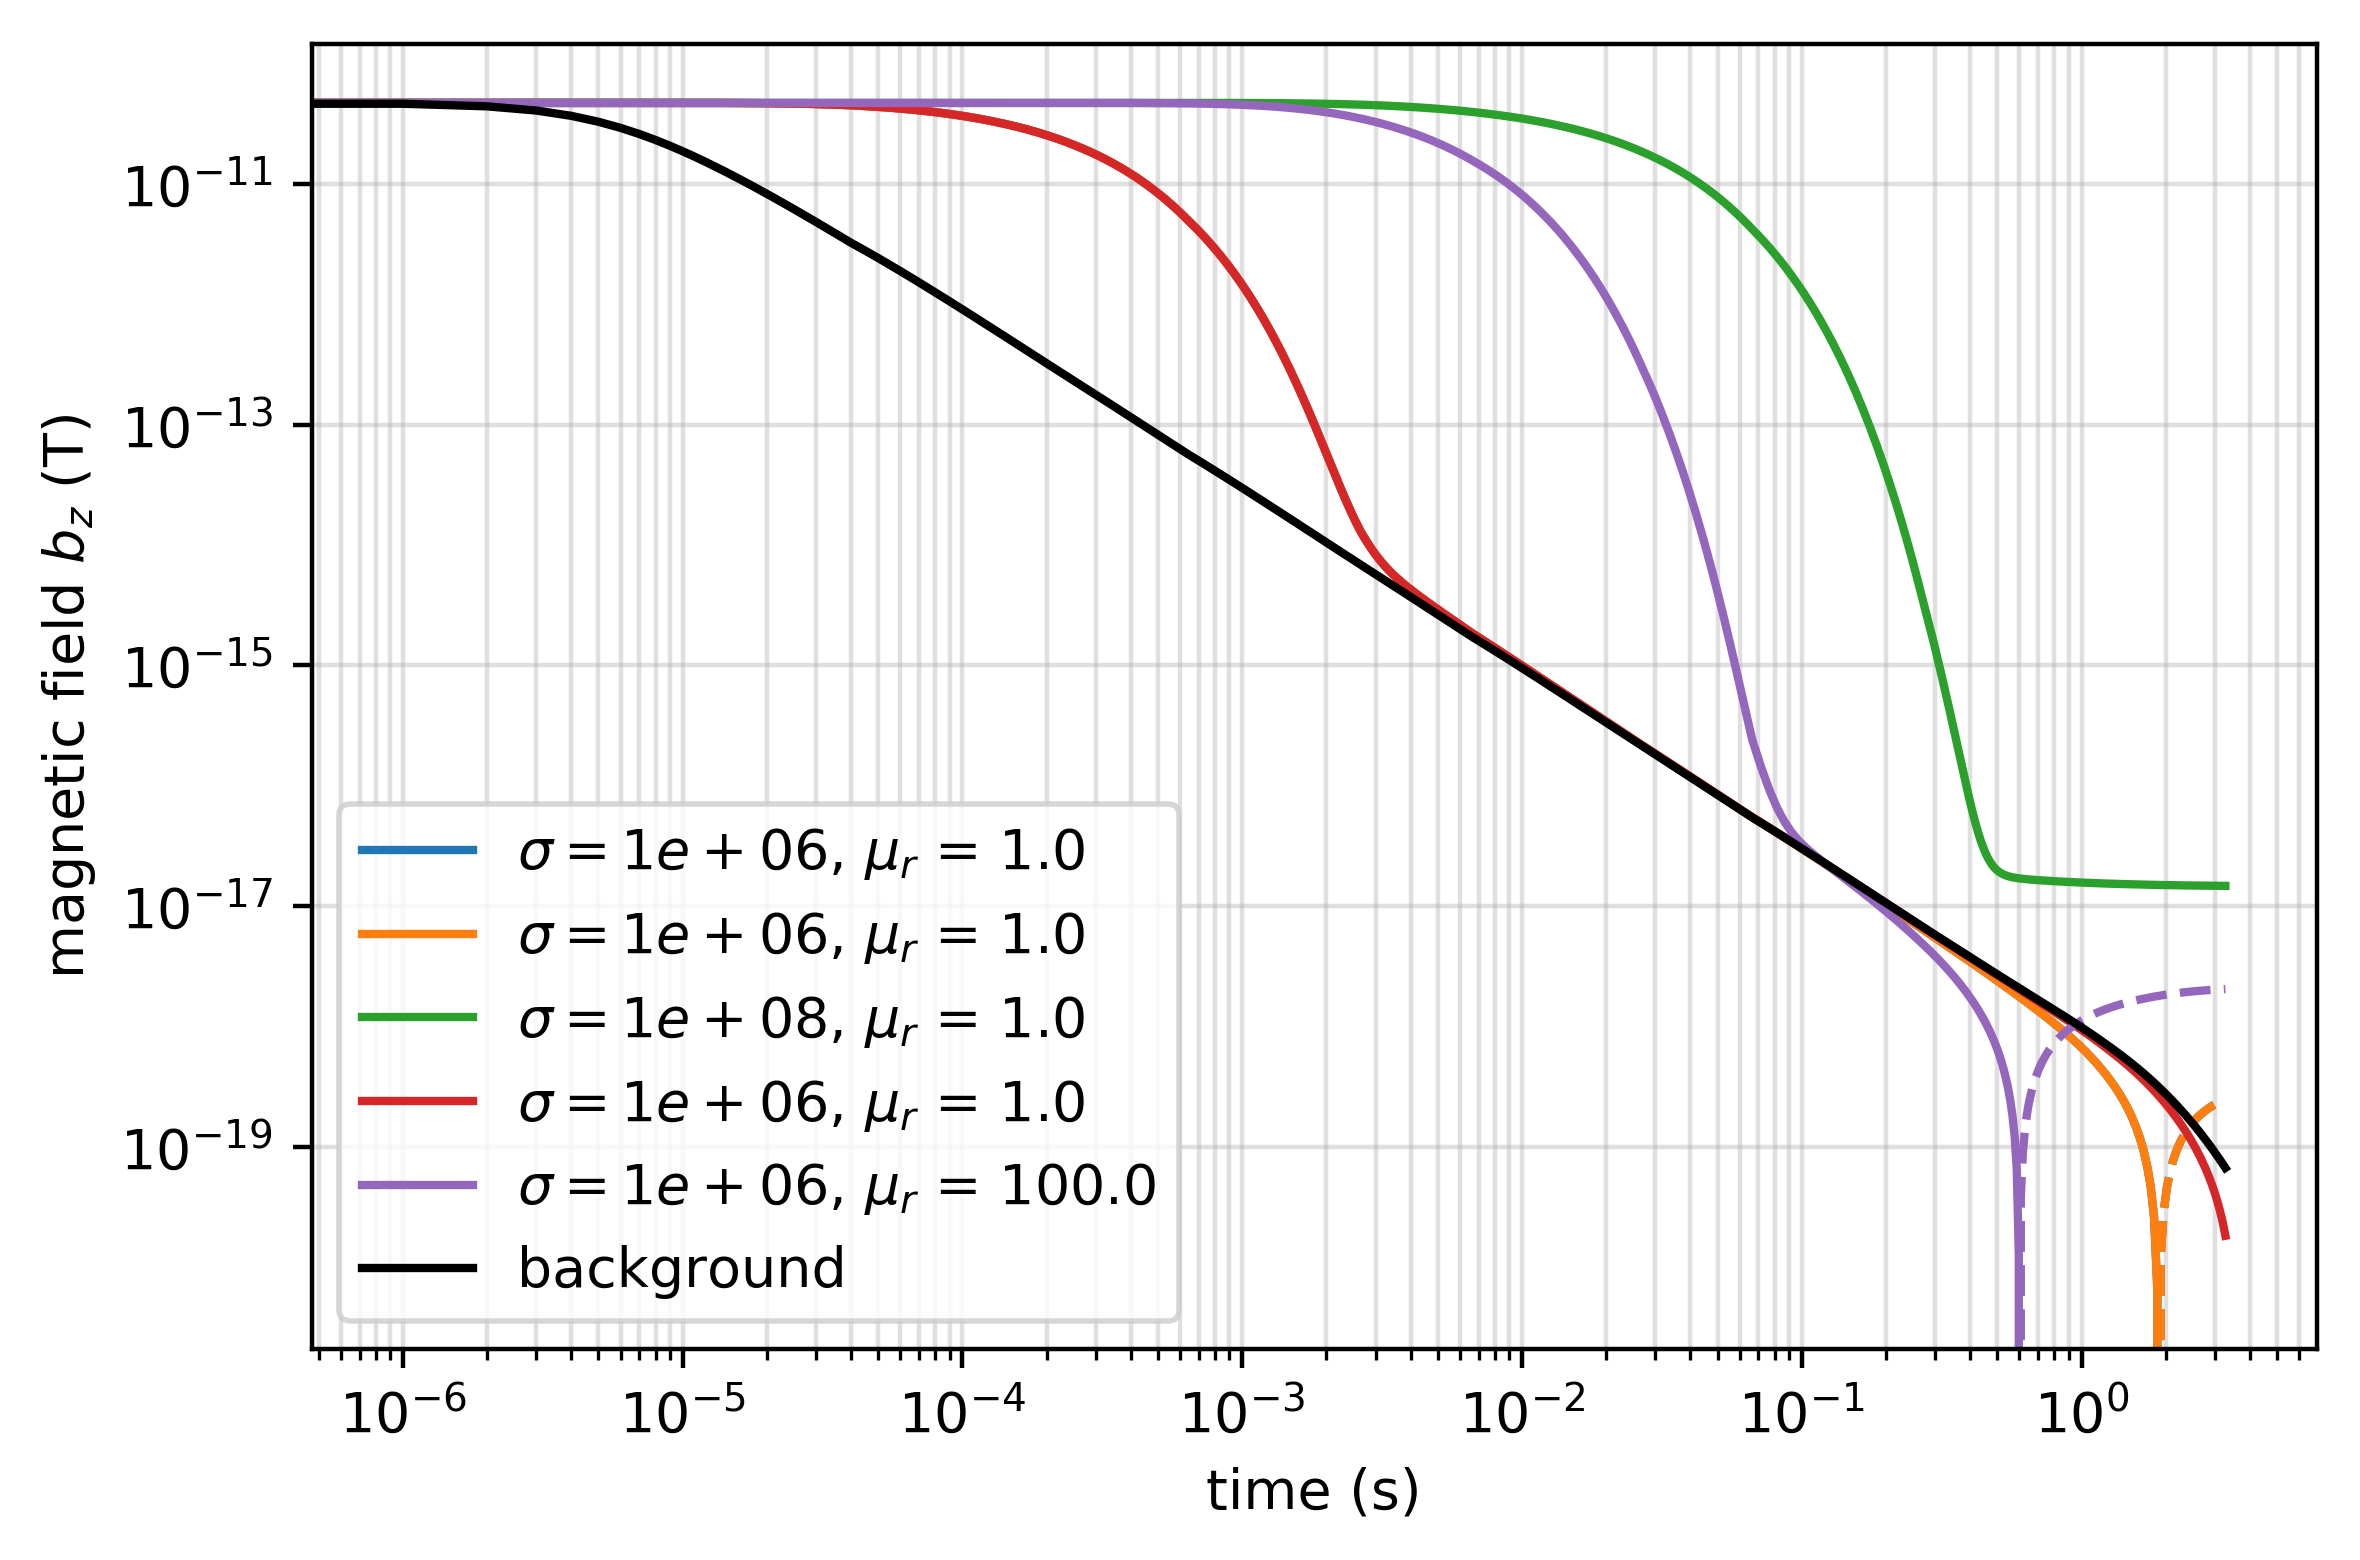

In [25]:
ax = plot_data()
# ax[0].set_xlim([3e-6, 2e-1])

## Normalized secondary field

Text(112.792,0.5,u'NSF')

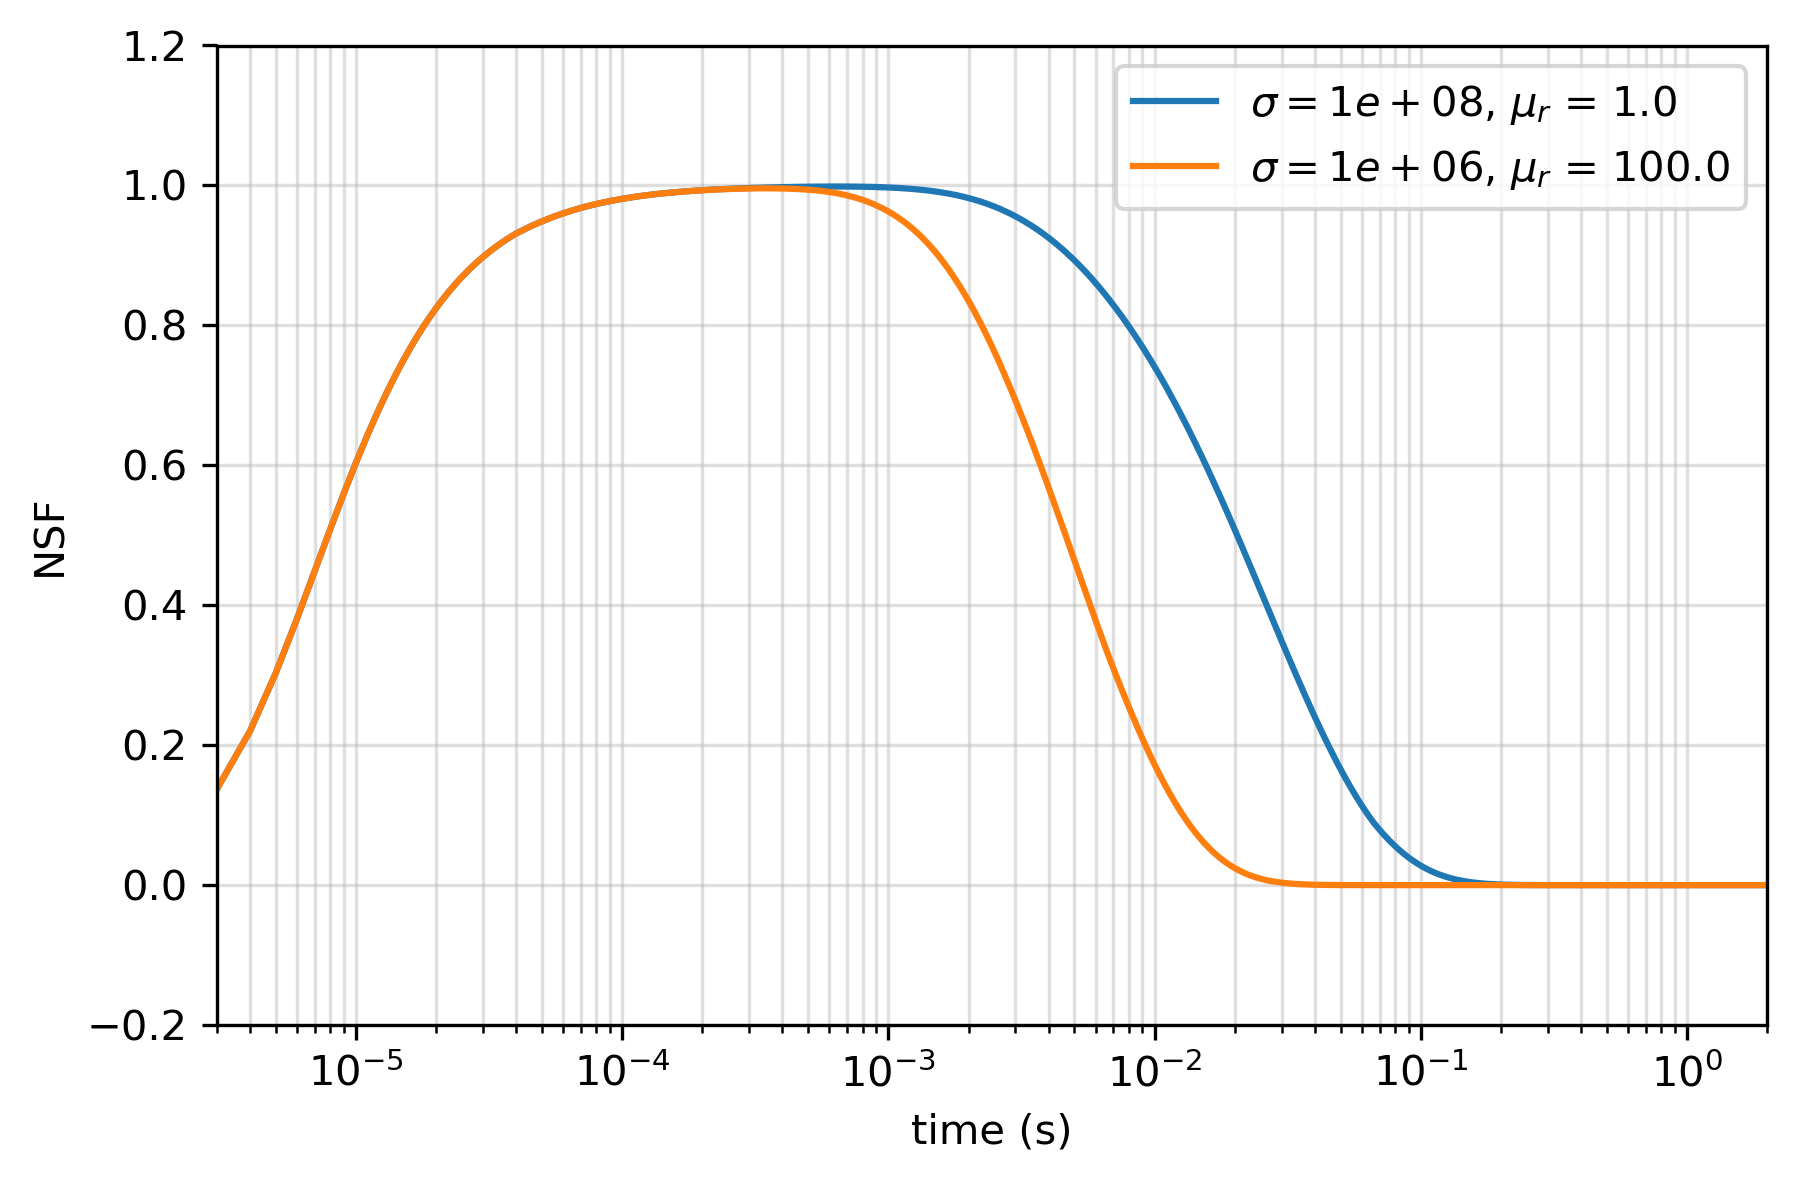

In [33]:
fig, ax = plt.subplots(1, 1, dpi=300)
ax = plot_data(scale="semilogx", subtract="NSF", models=["casing_1e+08", "casing_100"], ax=[ax])
ax[0].set_xlim([3e-6, 2])
ax[0].set_ylim([-0.2, 1.2])
ax[0].set_ylabel("NSF")
# ax[0].set_ylim([1e-18, 0.5e-10])

In [34]:
fig.savefig("tdemNSF")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=400)
ax = [ax]
scale = "semilogx"
subtract = "NSF"

# for i, key in enumerate(model_names[1:-1]):
label = "$\mu_r$ = {}".format(key.split("_")[-1])

# conductive, permeable casing
key_mu = 'casing_100'
key_sigma_mu = 'casing_1e+08'

plotme = data[key_mu]
plotme_sigma_mu = data[key_sigma_mu]

if subtract in ["wholespace", "NSF"]:
    plotme = plotme - data["baseline"]
    plotme_sigma_mu = plotme_sigma_mu - data["baseline"]
    
    if subtract == "NSF":
        plotme = plotme / data["baseline"][0]
        plotme_sigma_mu = plotme_sigma_mu / data["baseline"][0]
        
elif subtract in "conductive":
    plotme = plotme - data["casing_1"]
    plotme_sigma_mu = plotme_sigma_mu - data["casing_1"]
    
else:
    getattr(ax[0], scale)(
        rx.times, data['baseline'], "-", color='k', label="background"
    )
    

getattr(ax[0], scale)(
    rx.times, plotme_sigma_mu, color="C0",
    label="$\sigma$ = {:1.1e}, $\mu_r$ = {}".format(model_dict[key_sigma_mu].sigma_casing, model_dict[key_sigma_mu].mur_casing)
)
getattr(ax[0], scale)(
    rx.times, plotme, color="C1", 
    label="$\sigma$ = {:1.1e}, $\mu_r$ = {}".format(model_dict[key_mu].sigma_casing, model_dict[key_mu].mur_casing)
)



[a.set_xlabel("time (s)") for a in ax]
[a.set_ylabel("magnetic field $b_z$ (T)") for a in ax]

[a.grid(which='both', alpha=0.4) for a in ax]
[a.legend() for a in ax]

ax[0].set_xlim([3e-6, 2e-1])
# ax[0].set_ylim([1e-18, 0.5e-10])

plt.tight_layout()


# Build a widget

In [ ]:
# Plot the charges
# mesh2D = cylMeshGen.create_2D_mesh().mesh
mesh = mesh_generator.mesh
theta_ind=0

def plotCasingResults(
    ax = None,
    clim_max=None, clim_min=None, 
    max_depth=1.1*model_dict[model_names[0]].casing_l, 
    max_r=0.1, top=10., model='casing_1', 
    casing_outline=True, 
    field='b',
    tind=0, 
    subtract="none", 
    show_cb=True
):
    if ax is None: 
        plt.subplots(1, 1, figsize=(6, 7))

    xlim = max_r*np.r_[-1, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    clim = None
    plotopts = {
        'theta_ind': theta_ind,
        'pcolorOpts':{'norm':LogNorm()}
    }
    
    if clim_max is not None and clim_max != 0.:
        clim = clim_max * np.r_[-1, 1]
        plotopts['clim'] = clim

        if clim_min is not None and clim_min != 0.:
            plotopts['clim'][0] = clim_min

    pp = physprops[model]
    plotme = fields_dict[model][:, field, tind]
    
    if subtract == "wholespace":
        plotme = plotme - fields_dict["baseline"][:, field, tind]
    elif subtract == "conductive":
        plotme = plotme - fields_dict["casing_1"][:, field, tind]

    if field in ["h", "b"]:
        out = casingSim.plotFace2D(
            mesh,
            plotme + 1e-20, ax=ax, range_x=xlim,
            range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
            clim=clim, mirror=True, show_cb=show_cb, stream_threshold = clim[0] if clim is not None else None
        )
    elif field in ["e", "j"]:
        plotme = mesh.aveE2CC * plotme
        out = pp.plot_prop(
            np.absolute(getattr(plotme, component)),
            ax=ax,
            **plotopts 
        )
    ax.set_title(' {} {} \n t={:1.2e}'.format(field, model, prob.times[tind]), fontsize=13
    )
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
#         cb.set_label(casing)
#     cb.update_ticks()
        
    # plot outline of casing
    if casing_outline is True: 
        m = model_dict[model]
        factor = [-1, 1]
        [
            ax.plot(
                fact * np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
                np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
                'k', 
                lw = 0.5
            ) 
            for fact in factor
        ]
    return out 
    

def plotCasingResultsWidget(
    clim_max=None, clim_min=None, 
    max_depth=1.1*model_dict[model_names[0]].casing_l, 
    max_r=0.1, top=10., model='casing_1', 
    field='b',
    subtract="none",
    tind=0,  
):
    
    model_names = model_names if model == 'all' else [model]
    
    fig, ax = plt.subplots(1, len(model_names), figsize=(len(model_names)*5, 6))
    if len(model_names) == 1:
        ax = [ax]
    
    for a, mod in zip(ax, model_names): 
        a = plotCasingResults(
            ax = a,
            clim_max=clim_max, clim_min=clim_min, 
            max_depth=max_depth, 
            max_r=max_r, top=top, model=mod,  
            casing_outline=True, tind=tind, subtract=subtract
        )
    
    plt.tight_layout()
    plt.show()

# widget for view fields / fluxes
- clim_max, clim_min: colorbar limits. if 0, they are set by default
- max_depth: maximum depth of the plot
- max_r: maximum radius of the plot
- top: z above surface to plot
- casing: "conductive"  is $10^6 S/m$, "resistive" is $10^{-4} S/m$ is the same as the conductivity of the background
- model: permeability of the casing 
- field: field to plot
- subtract: subtract "none" = nothing, "wholespace" = removes effect of source in a resistive background, "conductive" = removes reponse due to conductive casing in a wholespace (mu = 1) 

In [ ]:
ipywidgets.interact(
    plotCasingResultsWidget,
    clim_max=ipywidgets.FloatText(value=0), 
    clim_min=ipywidgets.FloatText(value=0), 
    max_depth=ipywidgets.FloatText(value=1.5*casing_l), 
    max_r=ipywidgets.FloatText(value=0.15), 
    top=ipywidgets.FloatText(value=10.), 
    field=ipywidgets.ToggleButtons(options=['e', 'b', 'h', 'j'], value='b'),   
    model=ipywidgets.ToggleButtons(options=model_names),
    subtract=ipywidgets.ToggleButtons(options=["none", "wholespace", "conductive"]),
    tind=ipywidgets.IntSlider(min=0, max=len(prob.times)-1, value=0)
)

In [ ]:
from matplotlib import rcParams
rcParams['font.size'] = 16

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(3.5*5, 5.5*2))
fig.subplots_adjust(bottom=0.8)

clim = [3e-13, 3e-8]
max_depth = 2500
top = 10
max_r = 0.14
view='b'
# primsec="secondary"

tinds = [10, 52, 128, 207, 287]

for i, tind in enumerate(tinds):
    for j, m in enumerate(["casing_1e+08", "casing_100"]):
        a = ax[j, i]
        out = plotCasingResults(
            ax = a,
            clim_max=clim[1], clim_min=clim[0], 
            max_depth=max_depth, 
            max_r=max_r, top=top, field=view, model=m, 
            subtract="wholespace", 
            casing_outline=True,
            tind=tind, 
            show_cb=False
        )
        
        
        if j == 0:
            a.set_title("{:1.0e} s".format(times[tind]))
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
            
            
        else:
            a.set_title("")
            a.set_xlabel("x (m)")
    
        if i > 0:
            a.set_yticklabels(['']*len(a.get_yticklabels()))
            a.set_ylabel('')
        else:
            a.set_ylabel('z (m)')
            mod = model_dict[m]
            a.text(
                -0.13, -2400, "$\sigma = ${:1.0e}, $\mu_r = $ {:1.0f}".format(mod.sigma_casing, mod.mur_casing), 
                color="w", fontsize=18
            )


plt.tight_layout()


cbar_ax = fig.add_axes([0.15, -0.02, 0.75, 0.02])
cb = fig.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Magnetic flux density (T)')


In [ ]:
fig.savefig("btdem", dpi=300, bbox_inches="tight")

In [ ]:
model_dict["casing_1"].casing_t * 2 * np.pi * model_dict["casing_1"].casing_r / model_dict["casing_1"].casing_t

In [ ]:
model_dict["casing_1"].casing_t  * model_dict["casing_1"].casing_t / (2 * np.pi * model_dict["casing_1"].casing_r)

In [ ]:
1e6 + 0.00035367765131532296 * 1e6